In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
# %qtconsole

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)
np.random.seed(0)

## Load Data

In [4]:
from src.simulation import load_simulated_spikes_with_real_position

(position, spikes, is_training,
 place_field_centers, position_info) = load_simulated_spikes_with_real_position()

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Fit Classifier

In [5]:
from dask.distributed import Client, LocalCluster

client = Client(processes=False)

In [6]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.parameters import SAMPLING_FREQUENCY

continuous_transitions = (
    [['random_walk', 'uniform', 'uniform'],
     ['uniform',     'uniform', 'uniform'],
     ['uniform',     'uniform', 'identity']])

classifier = SortedSpikesClassifier(
        movement_var=16, replay_speed=1,
        place_bin_size=4.0, continuous_transition_types=continuous_transitions,
        discrete_transition_diag=1-1e-2
).fit(position, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/worker.py:2791: UserWarning: Large object of size 7.45 MB detected in task graph: 
  (array([0., 0., 0., ..., 0., 0., 0.]), 'ndarray-c3 ... 65ebddd', 10.0)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


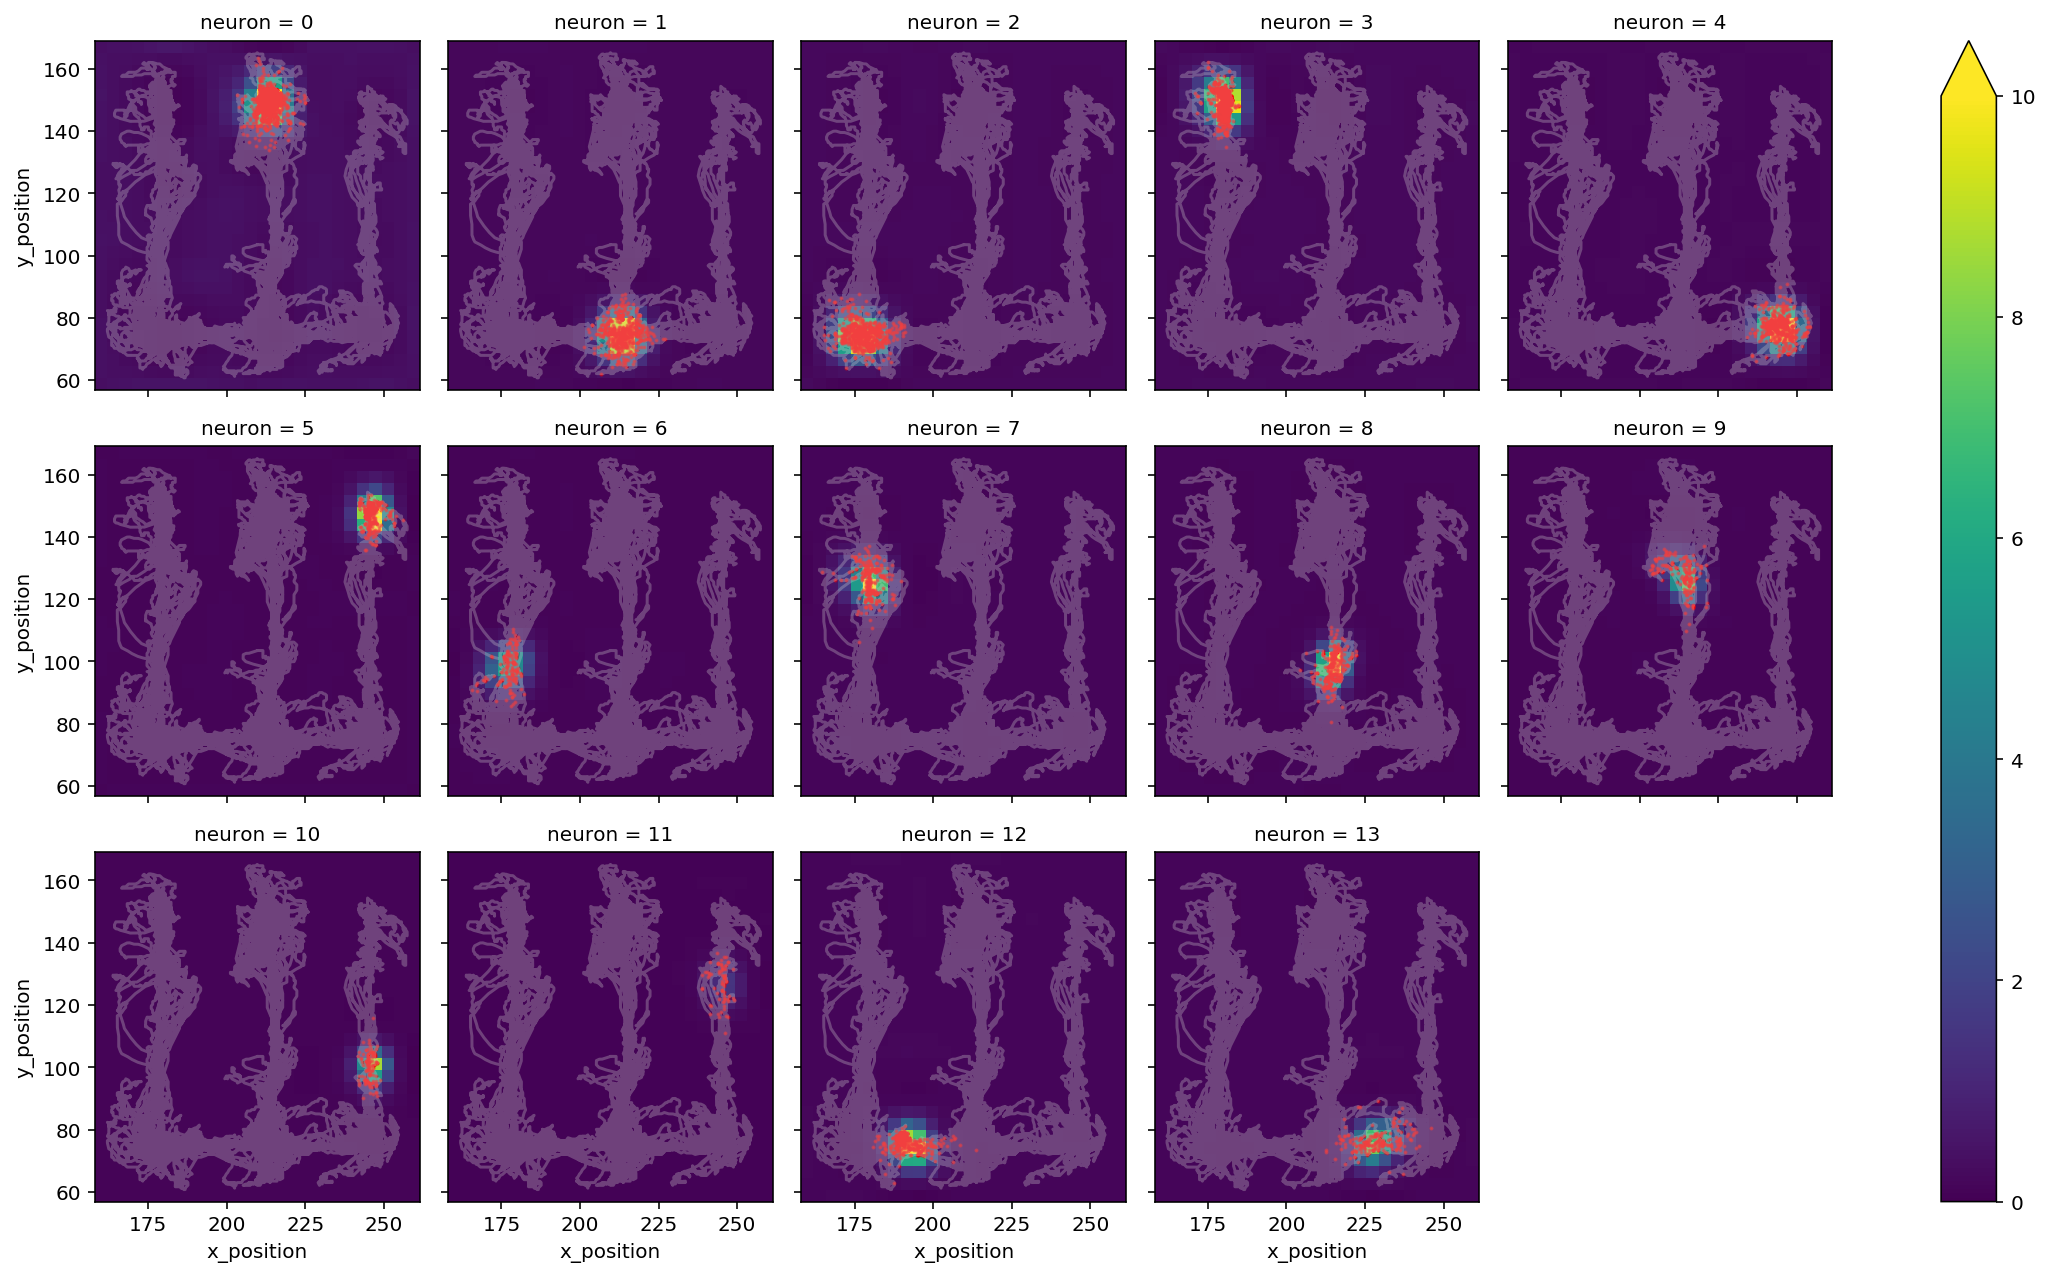

In [7]:
g = classifier.plot_place_fields(
    spikes, position, SAMPLING_FREQUENCY)

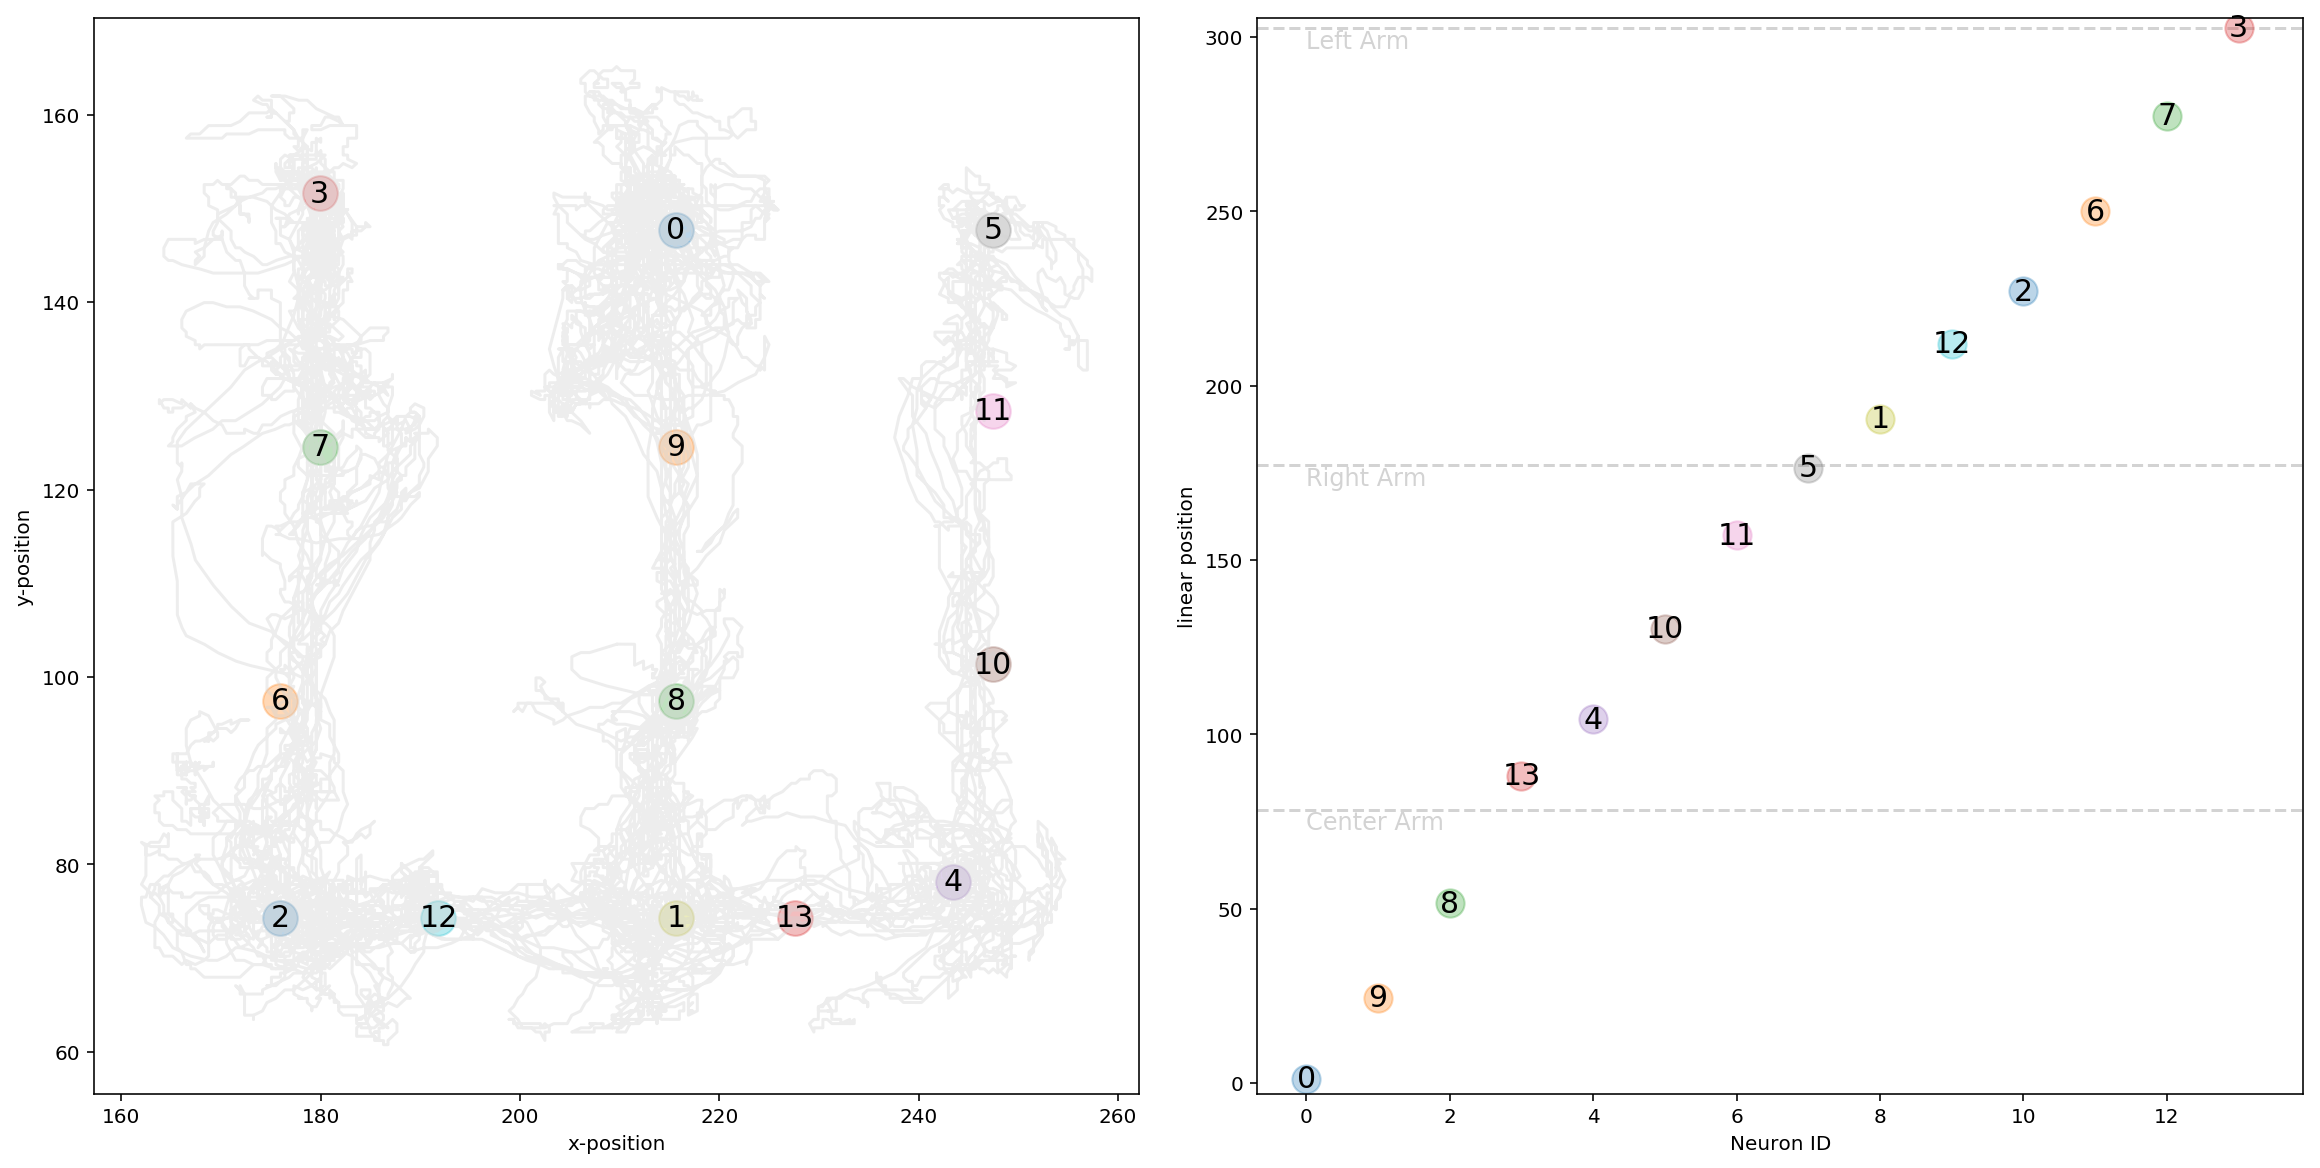

In [8]:
from src.analysis import get_linear_position_order, get_place_field_max
from src.visualization import plot_neuron_place_field_2D_1D_position

place_field_max = get_place_field_max(classifier)
linear_position_order, linear_place_field_max = get_linear_position_order(
    position_info, place_field_max)
plot_neuron_place_field_2D_1D_position(
    position_info, place_field_max, linear_place_field_max, 
    linear_position_order)

## Test Cases

### Continuous

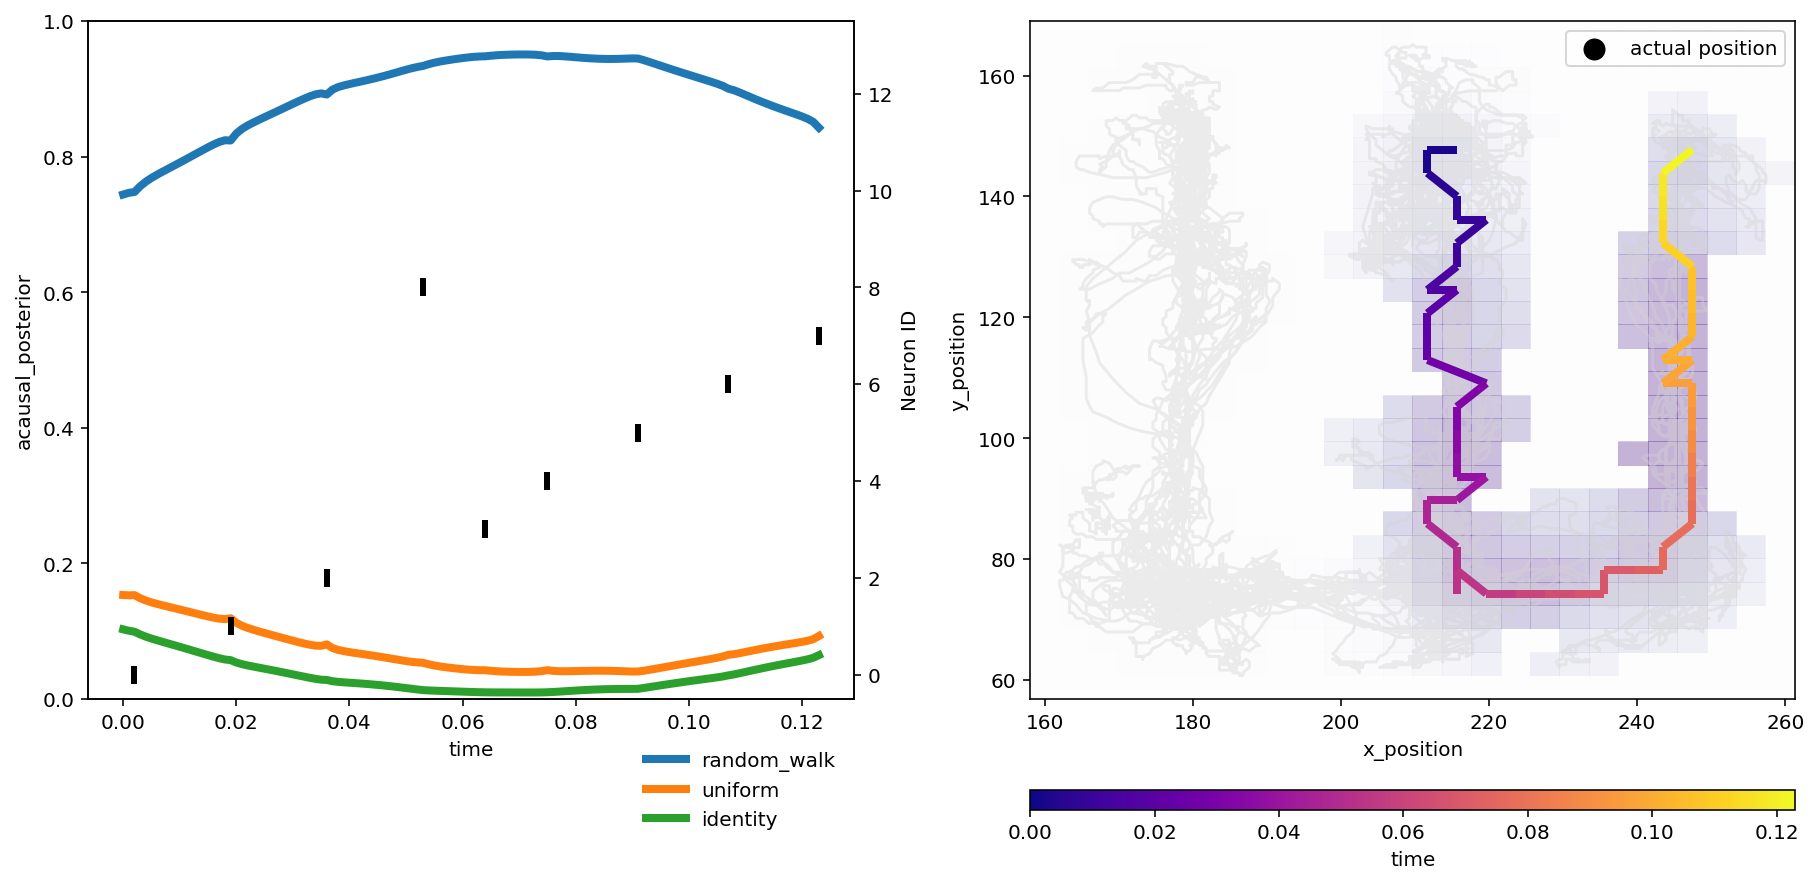

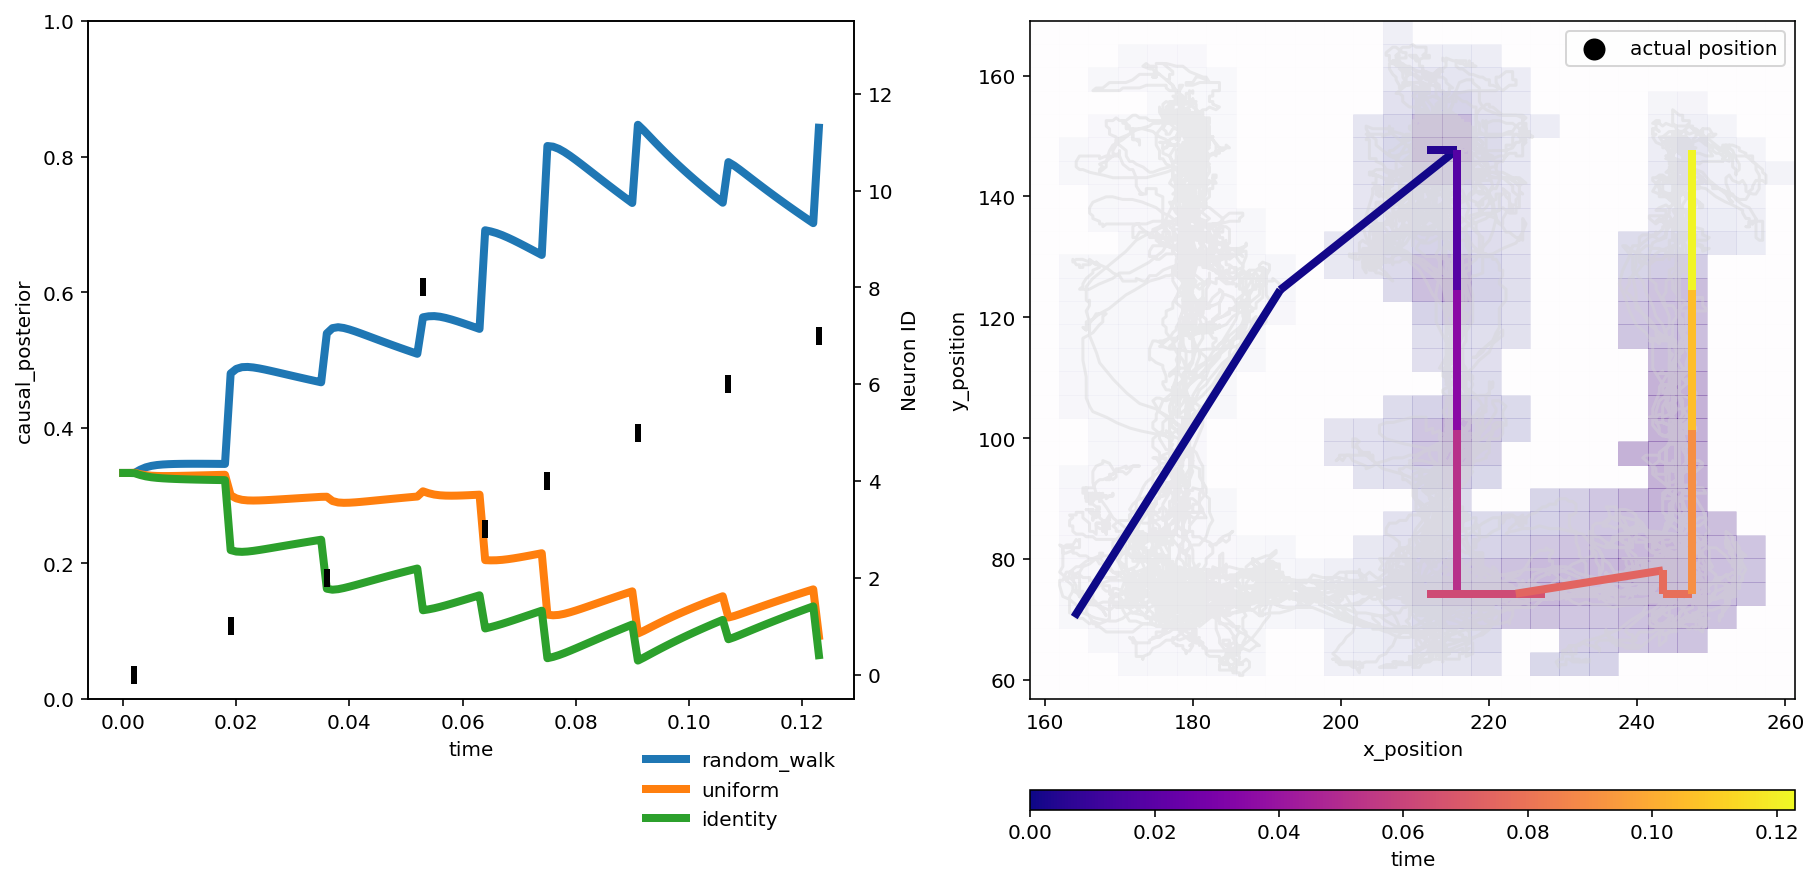

In [9]:
from src.simulation import continuous_replay
from src.visualization import plot_ripple_decode

test_spikes, time = continuous_replay(place_field_centers, 1500)
result = classifier.predict(test_spikes, time)

ripple_position = np.zeros((time.size, 2))
plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)
plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [10]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.99)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=123), Output()), _dom_classes=('widget-in…

In [11]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=n_time-1):
    g = (result.acausal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.999)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=123, description='time_ind', max=123), Output()), _dom_classes=('widget-…

### Hover

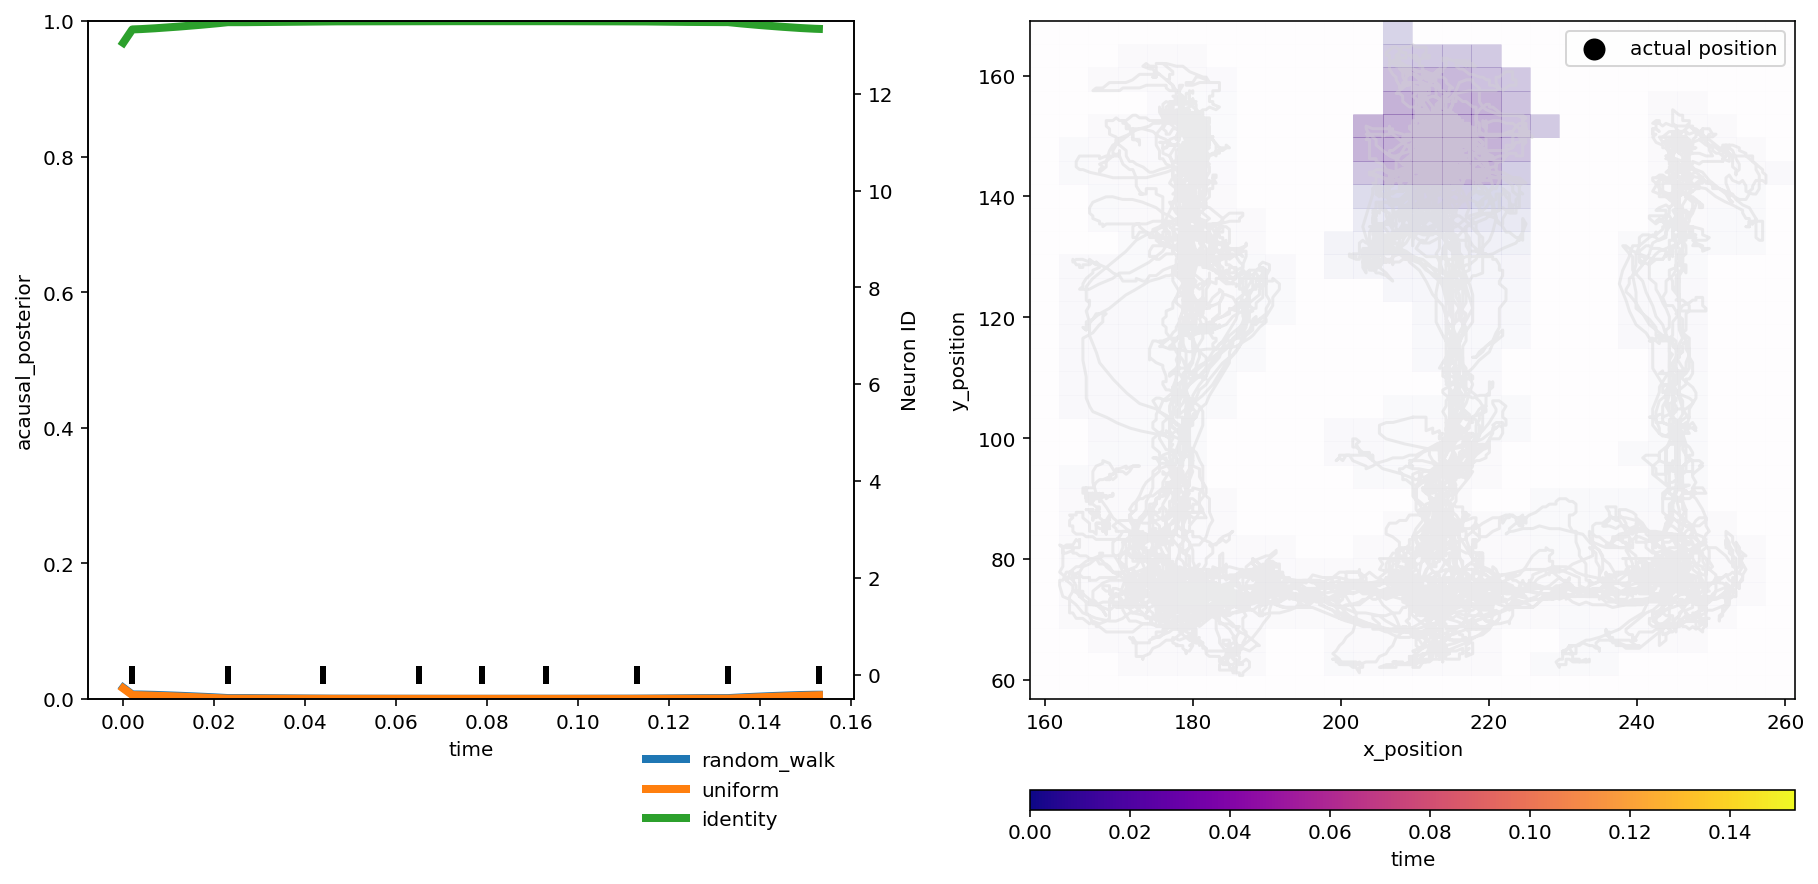

In [12]:
from src.simulation import hover_replay

test_spikes, time = hover_replay(place_field_centers)
result = classifier.predict(test_spikes, time)

ripple_position = np.zeros((time.size, 2))
plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [13]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.99)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=153), Output()), _dom_classes=('widget-in…

### Fragmented

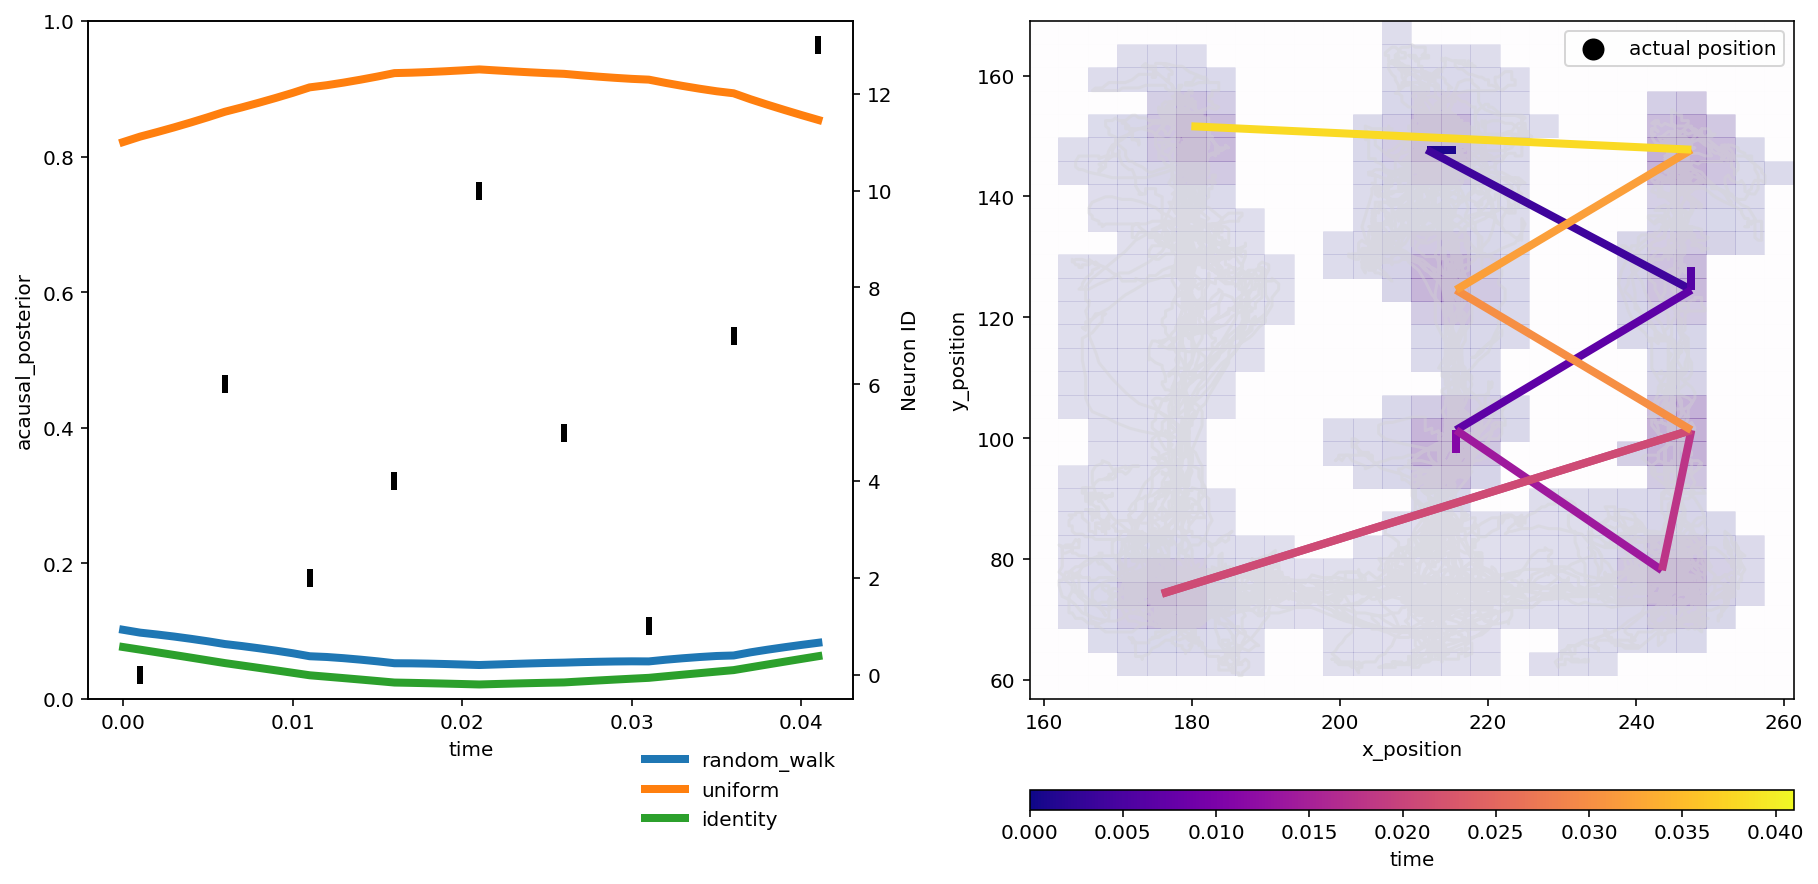

In [14]:
from src.simulation import fragmented_replay

test_spikes, time = fragmented_replay(place_field_centers)
result = classifier.predict(test_spikes, time)

ripple_position = np.zeros((time.size, 2))
plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [15]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.99)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=41), Output()), _dom_classes=('widget-int…

### Hover-Continuous-Hover

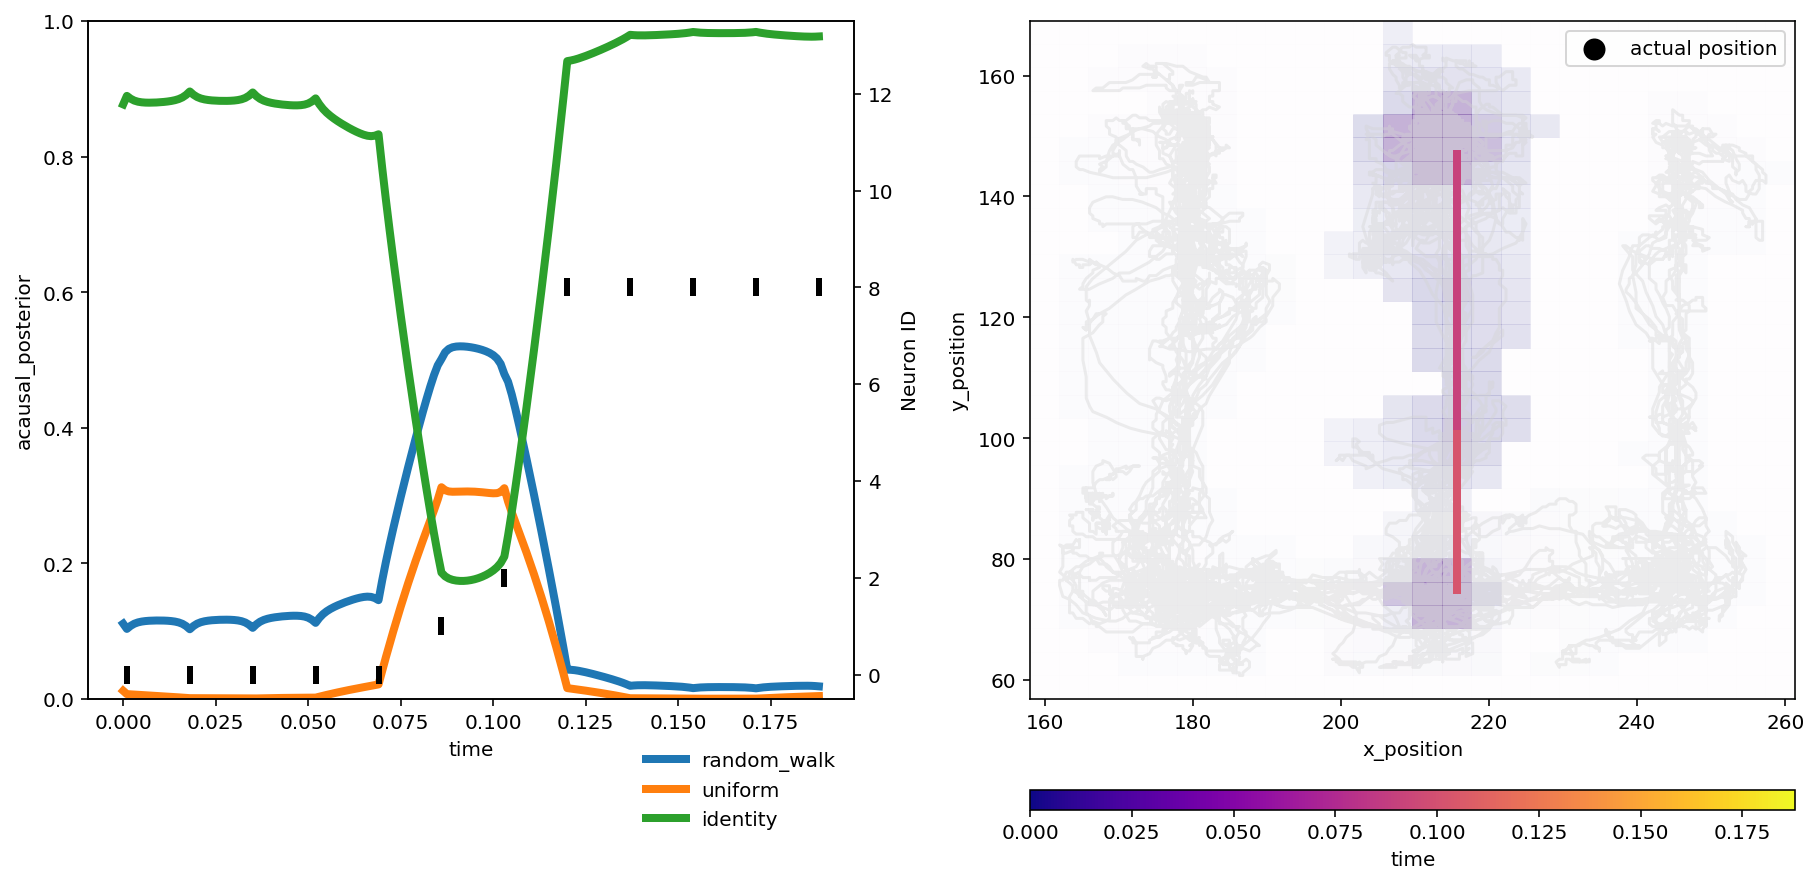

In [16]:
from src.simulation import hover_continuous_hover_replay

test_spikes, time = hover_continuous_hover_replay(place_field_centers)
result = classifier.predict(test_spikes, time)

ripple_position = np.zeros((time.size, 2))
plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

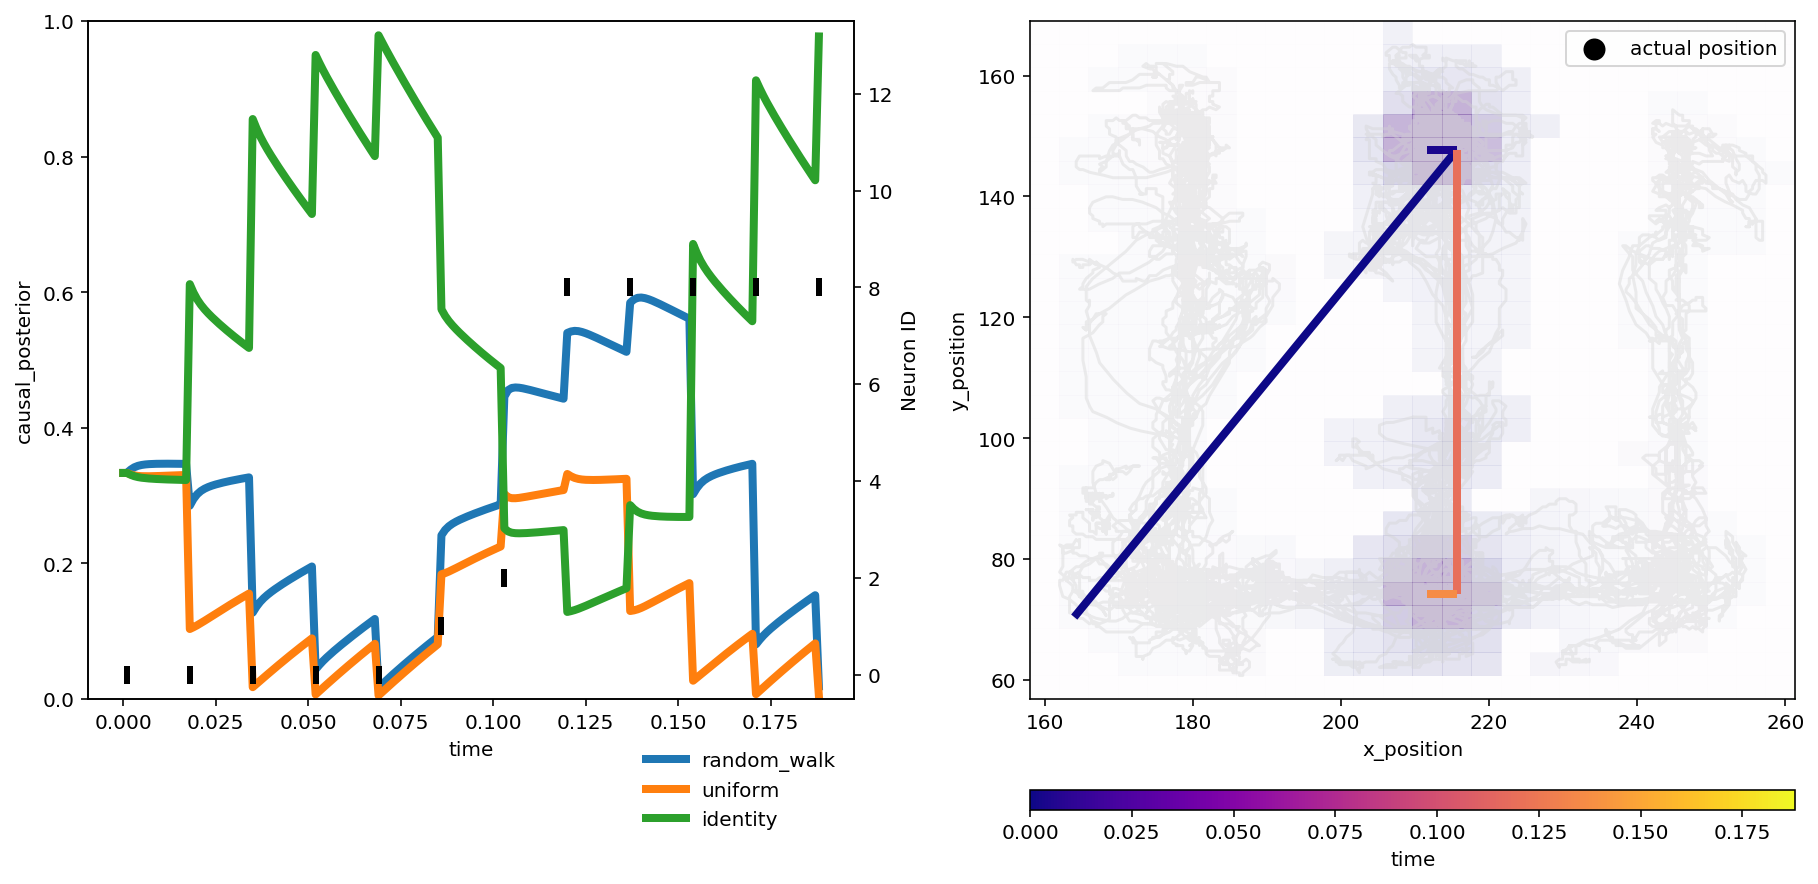

In [17]:
plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [18]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.99)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=188), Output()), _dom_classes=('widget-in…

In [19]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=n_time-1):
    g = (result.acausal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.999)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=188, description='time_ind', max=188), Output()), _dom_classes=('widget-…

### Continuous-Fragmented-Continuous

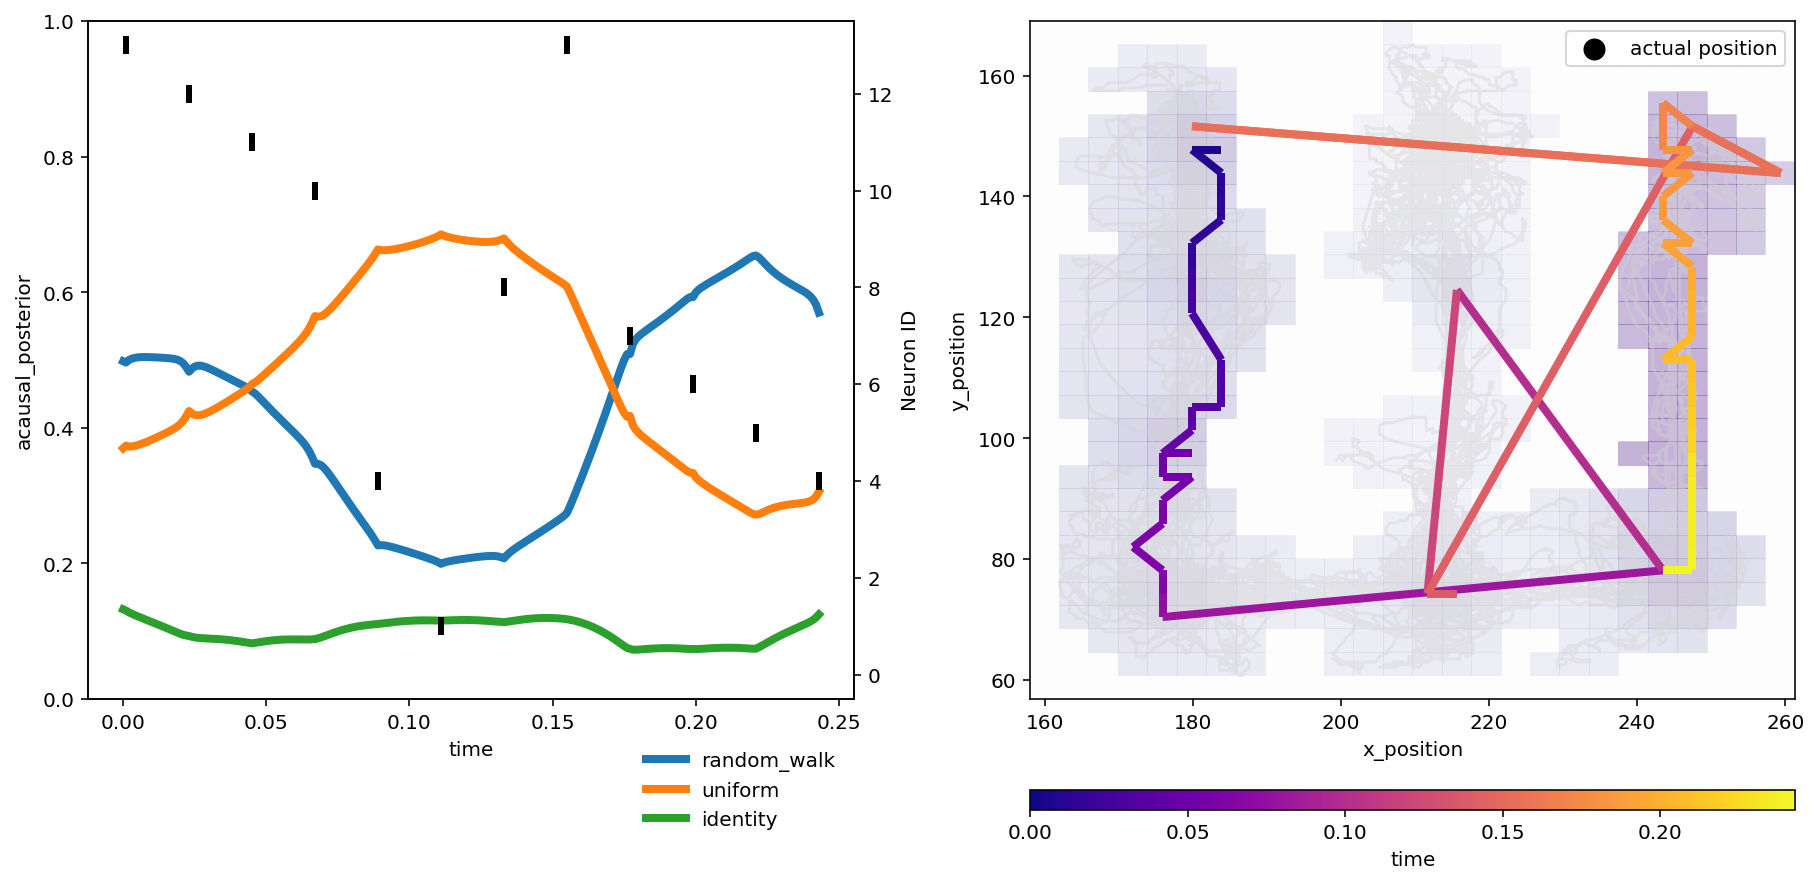

In [20]:
from src.simulation import continuous_fragmented_continuous_replay

test_spikes, time = continuous_fragmented_continuous_replay(place_field_centers)
result = classifier.predict(test_spikes, time)

ripple_position = np.zeros((time.size, 2))
plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

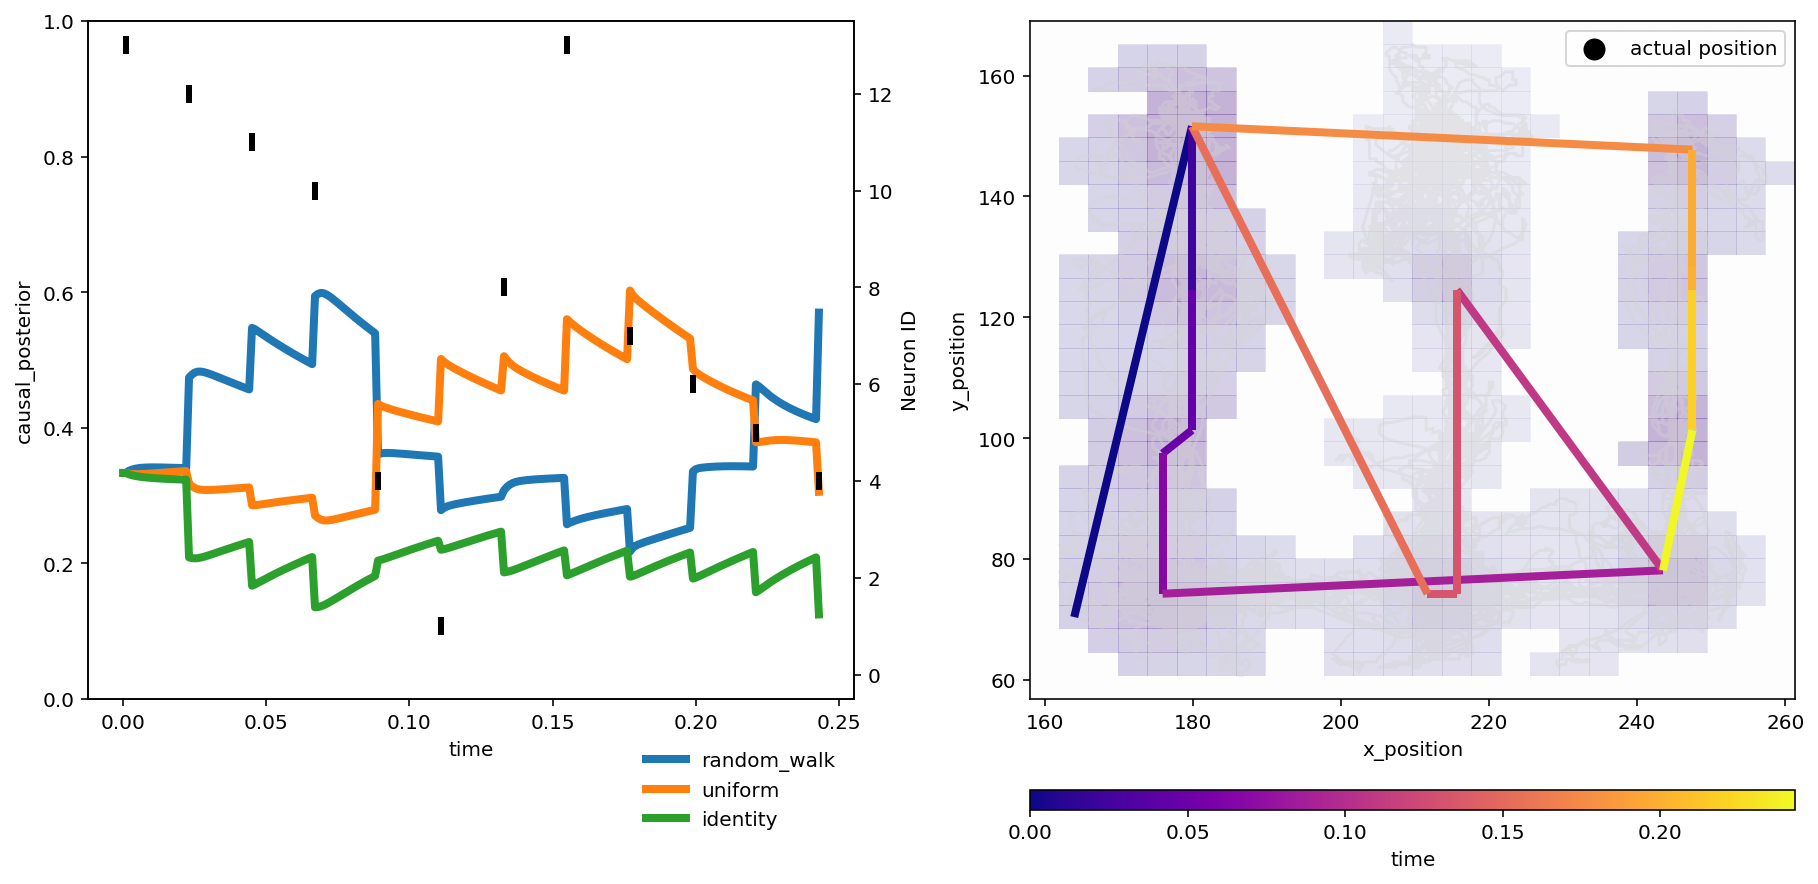

In [21]:
plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [22]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.isel(state=0).causal_posterior.quantile(0.9)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')
    g = (result.likelihood
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, robust=True))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=243), Output()), _dom_classes=('widget-in…

### Hover-Fragmented-Hover

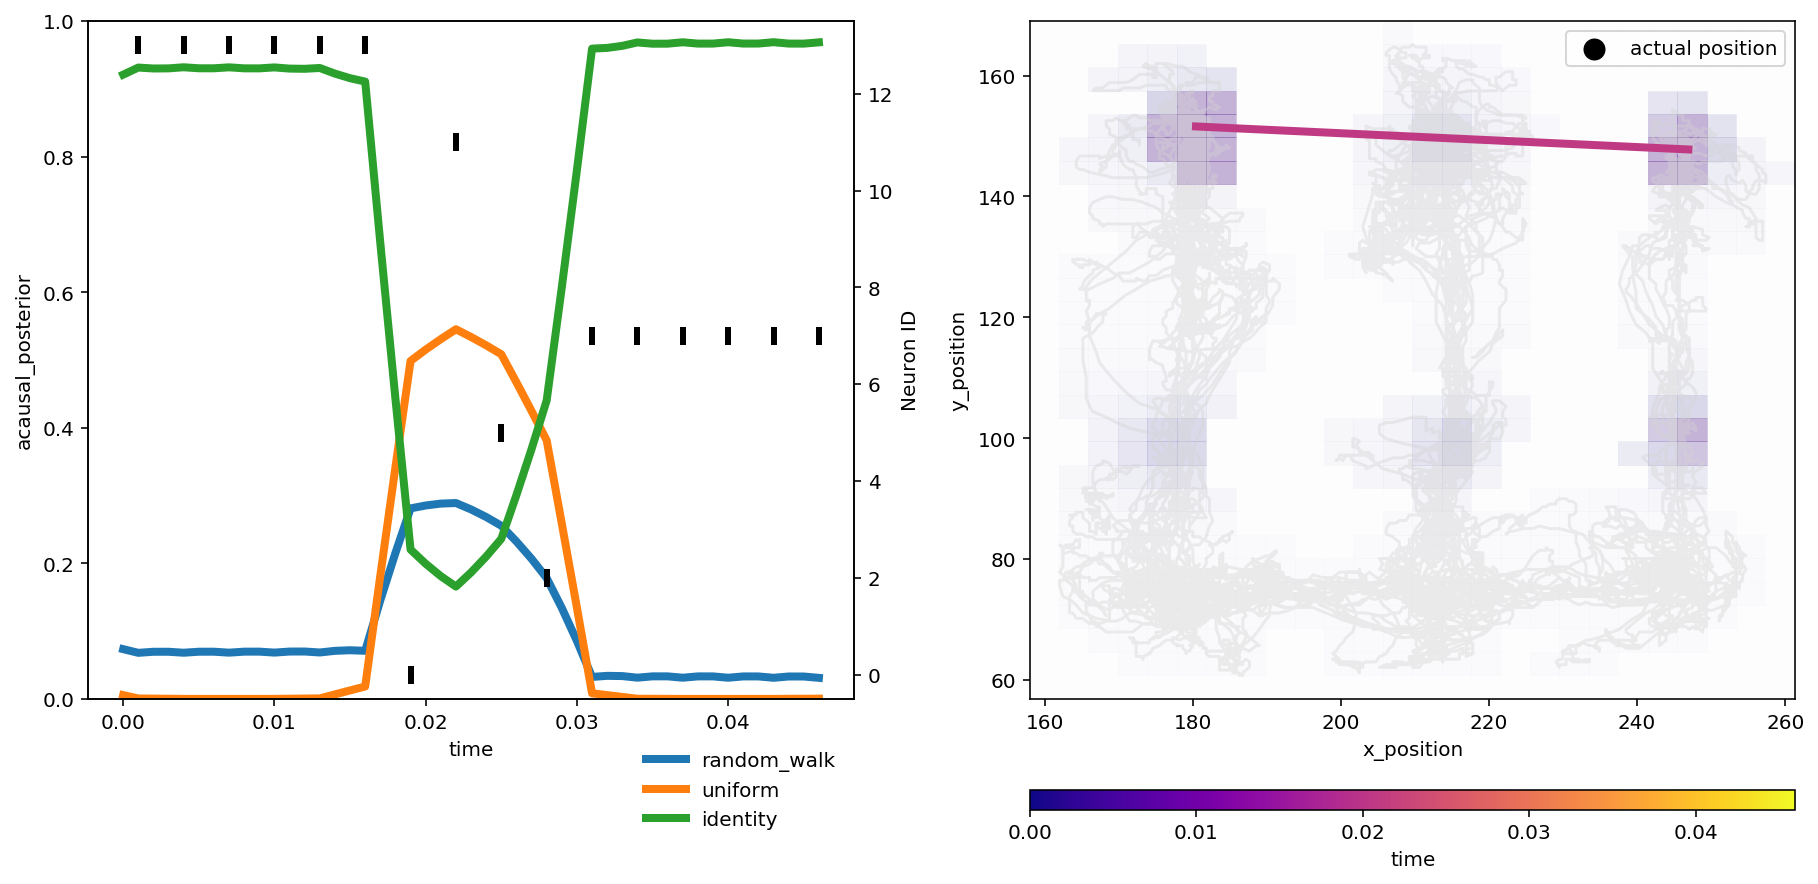

In [23]:
from src.simulation import hover_fragmented_hover_replay

test_spikes, time = hover_fragmented_hover_replay(place_field_centers)
result = classifier.predict(test_spikes, time)

ripple_position = np.zeros((time.size, 2))
plot_ripple_decode(result.acausal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

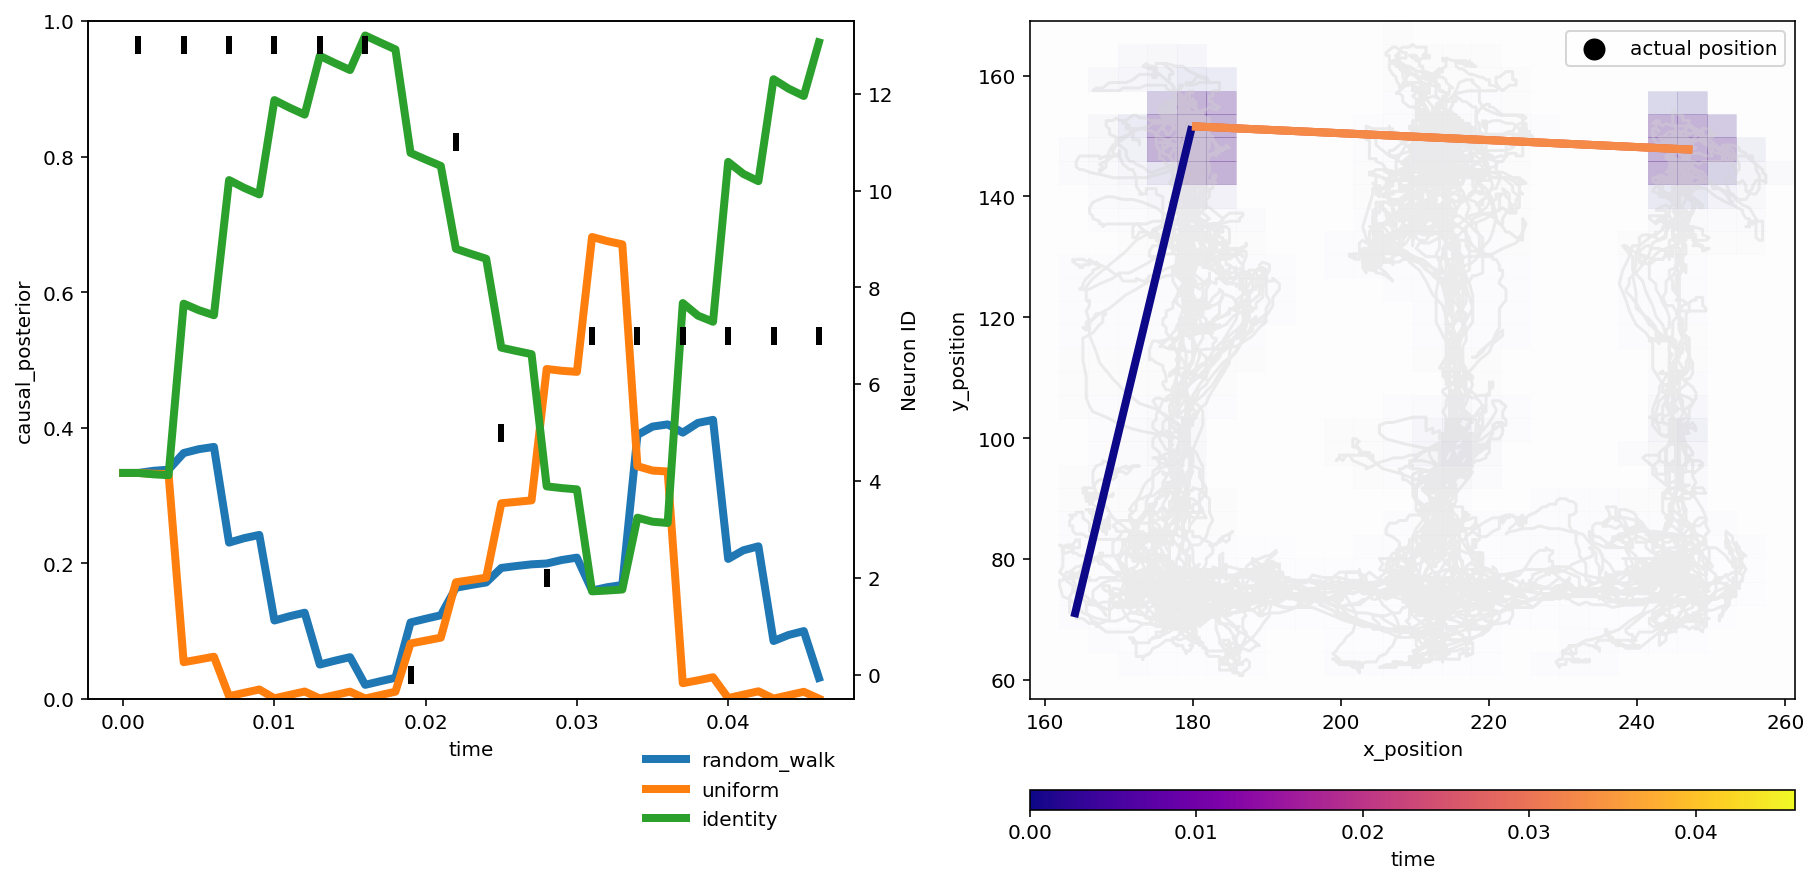

In [24]:
plot_ripple_decode(result.causal_posterior, ripple_position,
                   test_spikes, position, linear_position_order)

In [25]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=0):
    g = (result.causal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.99)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=0, description='time_ind', max=46), Output()), _dom_classes=('widget-int…

In [26]:
from ipywidgets import interact

n_time = result.time.size

@interact(time_ind=(0, n_time-1))
def _plot_result(time_ind=n_time-1):
    g = (result.acausal_posterior
         .isel(time=time_ind)
         .plot(x='x_position', y='y_position', col='state',
               size=5, vmin=0.0, vmax=result.causal_posterior.quantile(0.999)))
    for ax in g.axes.flat:
        ax.plot(position[:, 0], position[:, 1], alpha=0.3, color='lightgrey')

interactive(children=(IntSlider(value=46, description='time_ind', max=46), Output()), _dom_classes=('widget-in…